# 👥 Speaker diarization using Pyannote
_by Marianne de Heer Kloots, June 2025_

Speech datasets with audio recordings sometimes come with transcriptions of _what_ is being said, possibly even including timestamps to derive _when_ things were said and/or speaker information on _who_ was talking. But when you record your own audio, you might only have access to the .wav file(s) recorded by your microphone(s), which don't have this information.

_Speaker diarization_ is the task of figuring out who was talking when: partitioning an audio stream into segments attributed to different speakers. In this notebook we'll use the [pyannote](https://github.com/pyannote/pyannote-audio) package to set up a basic speaker diarization pipeline for the Tragic Talkers dataset.

> ❗ **Note:** You probably want to activate a GPU backend to run the code in this notebook efficiently. <br>
> Click _Runtime > Change runtime type_ in the menu above this notebook to select a GPU runtime (your current session will disconnect and restart).

> ❗ **Note:** To use the pyannote package, you'll first need to
> 1. Create an account on the [HuggingFace hub](https://huggingface.co/);
> 2. Accept the conditions for [pyannote/segmentation-3.0](https://hf.co/pyannote/segmentation-3.0) and [pyannote/speaker-diarization-3.1](https://hf.co/pyannote/speaker-diarization-3.1) <br>
> (see the [pyannote README](https://github.com/pyannote/pyannote-audio?tab=readme-ov-file#tldr) )

> Then, create your [HF_TOKEN](https://huggingface.co/docs/hub/security-tokens) on the HuggingFace hub, and add it as a secret to your colab environment (click the key 🔑 symbol in the menu to the left of this notebook), or run the code cell below:

In [1]:
from huggingface_hub import login
login()

Run the two cells below to download the preprocessed Tragic Talkers subset and install the pyannote library (no need to closely read their contents).

In [2]:
# @title Download data
!rm -rf 'sample_data'
!gdown -qq 1RXQ3u5RRsSq50mQWKDTj1rpKMUnTqIh0
!unzip -qq tragictalkers_speech_subset.zip
!rm tragictalkers_speech_subset.zip

In [3]:
# @title Install libraries
!pip install -qq pyannote.audio pyannote.core[notebook]

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We first load our needed imports and some helper functions.

In [4]:
from pyannote.audio import Pipeline
from pyannote.core.notebook import Notebook
import torch
import matplotlib.pyplot as plt
import pandas as pd
import glob
import IPython.display as ipd
from IPython.display import Audio
notebook = Notebook()

In [5]:
# helper functions
def find_wav_filepath(recording_name, mic_id):
  """
  Find the audio file for the specified recording and microphone.
  """
  return glob.glob(f'audio_subset/{recording_name}/{mic_id}-*.wav')[0]

def audio_player(audio_file):
  return ipd.display(Audio(audio_file))

The cell below runs the pyannote diarization pipeline for a single audio file from the Tragic Talkers subset. It outputs the estimated speech segments and speakers, as well as a player for the audio recording and the reference segments and transcripts, so you can evaluate the outcome of the pyannote diarizations yourself.

> **Exercise:** Explore the resulting diarization outputs for a few different recordings (named by the titles of their corresponding directories within `audio_subset/`) and microphone tracks (`17` & `18`: Romeo's and Juliet's lav mics respectively; `19`: the ambisonic ceiling mic), by changing the `rec_name` and `mic_id` variables and re-running the cell.
>
> Also examine how the diarization results change when the (exact) number of speakers is not specified beforehand by uncommenting the other diarization pipeline commands.
>
> What types of diarization errors can you spot? (See the diagram below by Hervé Bredin)
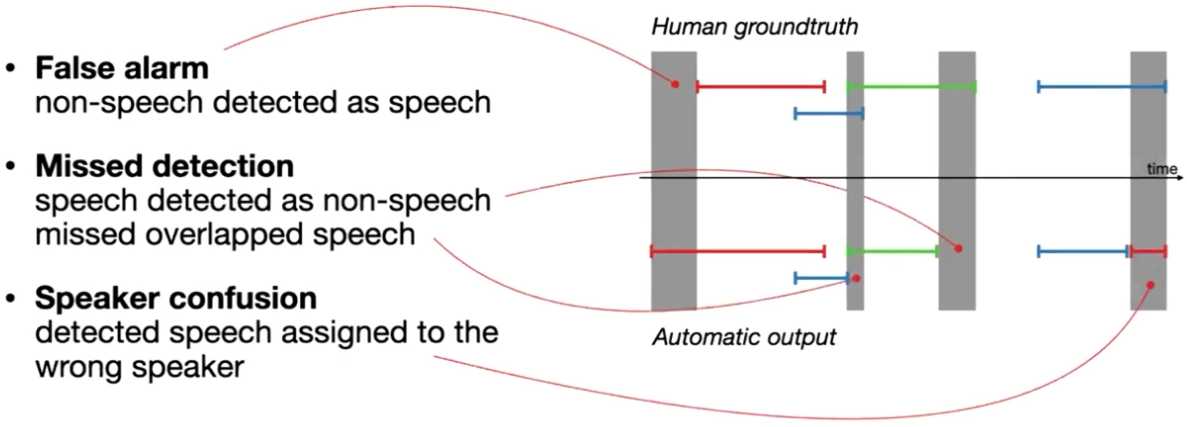

/usr/local/lib/python3.11/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std = sequences.std(dim=-1, correction=1)


start=1.9s stop=2.4s speaker=SPEAKER_00
start=2.6s stop=3.1s speaker=SPEAKER_01
start=3.6s stop=5.1s speaker=SPEAKER_00
start=5.7s stop=6.5s speaker=SPEAKER_01
start=7.3s stop=8.1s speaker=SPEAKER_00
start=8.8s stop=10.1s speaker=SPEAKER_00
start=11.5s stop=13.0s speaker=SPEAKER_00
start=14.1s stop=14.9s speaker=SPEAKER_01
start=15.3s stop=16.2s speaker=SPEAKER_01


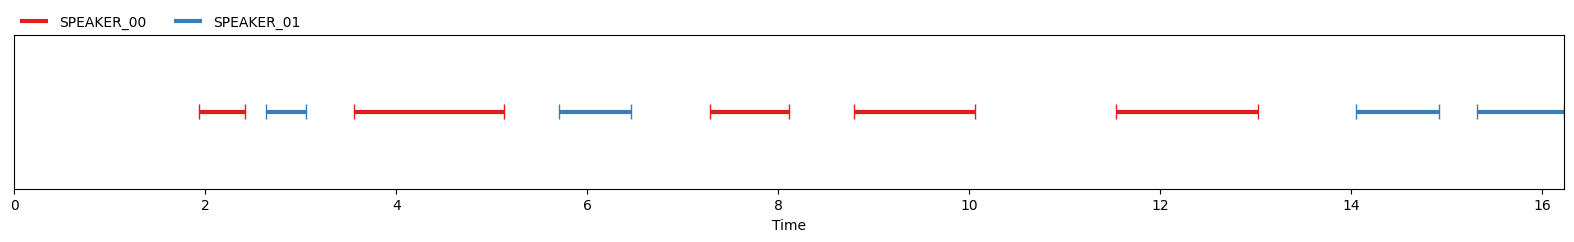

,recording,speaker,start_time,end_time,transcript
38,interactive2_t1,Juliet,1.93,2.47,Romeo!
39,interactive2_t1,Romeo,2.63,3.10,My dear?
40,interactive2_t1,Juliet,3.63,5.13,What oclock tomorrow shall I send to thee?
41,interactive2_t1,Romeo,5.70,6.43,By the hour of nine.
42,interactive2_t1,Juliet,7.33,13.07,I will not fail. Tis twenty year till then. I ...
43,interactive2_t1,Romeo,14.07,16.27,Then I should stay here to thee remember it.


In [10]:
rec_name = 'interactive2_t1'
mic_id = 19
audio_path = find_wav_filepath(rec_name, mic_id)

pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1")

# send pipeline to GPU if available
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
pipeline.to(device)

# run diarization with a known number of speakers beforehand
N_speakers = 2 if 'interactive' in rec_name or 'conversation' in rec_name else 1
diarization = pipeline(audio_path, num_speakers=N_speakers)

# # run diarization with a specified min and max number of speakers
# diarization = pipeline(audio_path, min_speakers=1, max_speakers=5)

# # run diarization without specifying the number of speakers
# diarization = pipeline(audio_path)

# print timestamps
for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker={speaker}")

# plot timeline
fig, ax = plt.subplots(figsize=(20,2))
notebook.plot_annotation(diarization, ax=ax)
ax.set_xlim(0, turn.end)
plt.show()

# play the recording
audio_player(audio_path)

# print the human-annotated transcripts for comparison
turn_transcripts = pd.read_csv('transcripts_subset/turn_transcripts.csv')
turn_transcripts[turn_transcripts['recording'] == rec_name]

If we want to use the detected speech segments and speaker labels in a further analysis step, we can save the diarization results to a dataframe and export to csv.

In [7]:
diarization_df = pd.DataFrame([(turn.start, turn.end, speaker) for turn, _, speaker in diarization.itertracks(yield_label=True)],
             columns=['start_time', 'end_time', 'speaker'])
diarization_df

,start_time,end_time,speaker
0,1.937844,2.410344,SPEAKER_00
1,2.629719,3.051594,SPEAKER_01
2,3.557844,5.127219,SPEAKER_00
3,5.700969,6.460344,SPEAKER_01
4,7.287219,8.114094,SPEAKER_00
5,8.789094,10.054719,SPEAKER_00
6,11.539719,13.024719,SPEAKER_00
7,14.054094,14.914719,SPEAKER_01
8,15.319719,16.230969,SPEAKER_01


In [8]:
diarization_df.to_csv(f'diarization_{rec_name}-{mic_id}.csv', index=False)

⏩ **Want to learn more** about the challenges of speaker diarization and other applications of pyannote? Check out [this lecture](https://umotion.univ-lemans.fr/video/9513-speech-segmentation-and-speaker-diarization/) by the creator of pyannote!